In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
ls

gdrive/  sample_data/


In [3]:
cd /content/gdrive/MyDrive/SemEval2023/SemEval2022-Task10/re_run

/content/gdrive/.shortcut-targets-by-id/1lC-ZKLaCDQyfLcof2Ak7FDa6IvTt318A/SemEval2023/SemEval2022-Task10/private_space


In [4]:
import pandas as pd

data = pd.read_csv("Data/starting_ki/train_all_tasks.csv")
# dfa = pd.read_csv("Data/dev_task_a_entries.csv")
# dfb = pd.read_csv("Data/dev_task_b_entries.csv")
# dfc = pd.read_csv("Data/dev_task_c_entries.csv")

In [5]:
data

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none
...,...,...,...,...,...
13995,sexism2022_english-14185,complexes like the 'nice chicks' that go after...,sexist,2. derogation,2.1 descriptive attacks
13996,sexism2022_english-18629,"""GRAPHIC Germany - Muslim ""refugee"" stabbing h...",not sexist,none,none
13997,sexism2022_english-3320,Lol I imagine there would be simps that are li...,not sexist,none,none
13998,sexism2022_english-13309,"It's not, the girls I go on dates with don't k...",not sexist,none,none


In [6]:
data[["text", "label_sexist"]].groupby("label_sexist").count()

,text
label_sexist,
not sexist,10602
sexist,3398


In [7]:
label_values = data["label_sexist"].unique()
label_values

array(['not sexist', 'sexist'], dtype=object)

In [8]:
texts = data['text'].values
labels = [1 if d=="sexist" else 0 for d in data['label_sexist'].values]

In [9]:
text_lengths = [len(texts[i].split()) for i in range(len(texts))]
print(min(text_lengths))
print(max(text_lengths))

1
55


# Prepare Data

In [10]:
!pip install -q transformers

In [11]:
import transformers

In [12]:
from transformers import BertTokenizer
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('Twitter/twhin-bert-base', do_lower_case=True)
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

print('Original Text: ', texts[0], '\n')
print('Tokenized Text: ', tokenizer.tokenize(texts[0]), '\n')
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[0])))


Original Text:  Damn, this writing was pretty chaotic 

Tokenized Text:  ['▁Dam', 'n', ',', '▁this', '▁writing', '▁was', '▁pretty', '▁cha', 'o', 'tic'] 

Token IDs:  [25844, 19, 4, 903, 32562, 509, 28875, 1608, 31, 9523]


In [13]:
text_ids = [tokenizer.encode(text, max_length=100, padding='max_length', truncation=True) for text in texts]
# text_ids = [tokenizer.encode(normalizeTweet(text), max_length=100, padding='max_length', truncation=True) for text in texts]

In [14]:
text_ids_lengths = [len(text_ids[i]) for i in range(len(text_ids))]
print(min(text_ids_lengths))
print(max(text_ids_lengths))


100
100


In [15]:
att_masks = []
for ids in text_ids:
    masks = [int(id > 0) for id in ids]
    att_masks.append(masks)

In [16]:
import torch
from sklearn.model_selection import train_test_split

train_x, test_val_x, train_y, test_val_y = train_test_split(text_ids, labels, random_state=42, test_size=0.2)
train_m, test_val_m = train_test_split(att_masks, random_state=42, test_size=0.2)

test_x, val_x, test_y, val_y = train_test_split(test_val_x, test_val_y, random_state=42, test_size=0.5)
test_m, val_m = train_test_split(test_val_m, random_state=42, test_size=0.5)


## Convert to tensor
train_x = torch.tensor(train_x);
test_x = torch.tensor(test_x);
val_x = torch.tensor(val_x);
train_y = torch.tensor(train_y);
test_y = torch.tensor(test_y);
val_y = torch.tensor(val_y);
train_m = torch.tensor(train_m);
test_m = torch.tensor(test_m);
val_m = torch.tensor(val_m);

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_x, train_m, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_x, val_m, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## Load Model

In [18]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification


num_labels = len(set(labels))

model = AutoModelForSequenceClassification.from_pretrained('Twitter/twhin-bert-base', num_labels=num_labels, output_attentions=False, output_hidden_states=False)
# model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=num_labels, output_attentions=False, output_hidden_states=False)

print("#Label", num_labels)

Some weights of the model checkpoint at Twitter/twhin-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-ba

#Label 2


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(device)

cuda


In [20]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# print('Number of trainable parameters:', count_parameters(model), '\n', model)


In [21]:
# model

## Fine-tune

In [22]:
learning_rate = 1e-5
adam_epsilon = 1e-8

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.2},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [23]:
from transformers import get_linear_schedule_with_warmup

num_epochs = 5
total_steps = len(train_dataloader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


In [24]:
import time
import numpy as np
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [25]:
# model

In [26]:
from tqdm import tqdm
from sklearn.metrics import f1_score
import os

train_losses = []
val_losses = []
num_mb_train = len(train_dataloader)
num_mb_val = len(val_dataloader)

tmp_out_dir = f'./Models/_tmp_x'
best_loss = None
best_epoch = -1

if num_mb_val == 0:
    num_mb_val = 1

for n in range(num_epochs):
    train_loss = 0
    start_time = time.time()
    
    for k, (mb_x, mb_m, mb_y) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        model.train()
        
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        mb_y = mb_y.to(device)
        
        outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
        loss = outputs[0]
        #loss = model_loss(outputs[1], mb_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.data / num_mb_train
    
    print ("\nTrain loss after itaration %i: %f" % (n+1, train_loss))
    train_losses.append(train_loss.cpu())
    
    val_loss = 0
    with torch.no_grad():
        model.eval()
        
        eval_score = []
        for k, (mb_x, mb_m, mb_y) in enumerate(val_dataloader):
            mb_x = mb_x.to(device)
            mb_m = mb_m.to(device)
            mb_y = mb_y.to(device)
        
            outputs = model(mb_x, attention_mask=mb_m, labels=mb_y)
            
            loss = outputs[0]
        
            _, predicted_values = torch.max(outputs[1], 1)
            predicted_values = predicted_values.cpu().numpy()
            true_values = mb_y.cpu().numpy()

            f1 = f1_score(true_values, predicted_values, average='macro')
            eval_score.append(f1)
            
            val_loss += loss.data / num_mb_val
        
        _score = np.mean(eval_score)
        print ("Validation loss after itaration %i: loss:%f f1:%f" % (n+1, val_loss, _score))
        val_losses.append(val_loss.cpu())
        
        
        if best_loss is None or best_loss < _score:
            
            if not os.path.exists(tmp_out_dir):
                os.makedirs(tmp_out_dir)
                
            model.save_pretrained(tmp_out_dir)
            # tokenizer.save_pretrained(tmp_out_dir)

            best_loss = _score
            best_epoch = n
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Time: {epoch_mins}m {epoch_secs}s')

print("LOAD", best_epoch)
model = AutoModelForSequenceClassification.from_pretrained(tmp_out_dir)
model = model.to(device)

100%|██████████| 350/350 [03:30<00:00,  1.67it/s]



Train loss after itaration 1: 0.505421
Validation loss after itaration 1: loss:0.405223 f1:0.705876
Time: 3m 42s


100%|██████████| 350/350 [03:37<00:00,  1.61it/s]



Train loss after itaration 2: 0.357025
Validation loss after itaration 2: loss:0.362302 f1:0.754769
Time: 3m 50s


100%|██████████| 350/350 [03:36<00:00,  1.62it/s]



Train loss after itaration 3: 0.299489
Validation loss after itaration 3: loss:0.367979 f1:0.761738
Time: 3m 48s


100%|██████████| 350/350 [03:36<00:00,  1.62it/s]



Train loss after itaration 4: 0.256761
Validation loss after itaration 4: loss:0.376254 f1:0.772917
Time: 3m 48s


100%|██████████| 350/350 [03:36<00:00,  1.62it/s]



Train loss after itaration 5: 0.230732
Validation loss after itaration 5: loss:0.396912 f1:0.780318
Time: 3m 48s
LOAD 4


In [45]:
import pickle
import os

out_dir = './Models/fine-tuned-twhinbert'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)


('./Models/fine-tuned-twhinbert/tokenizer_config.json',
 './Models/fine-tuned-twhinbert/special_tokens_map.json',
 './Models/fine-tuned-twhinbert/tokenizer.json')

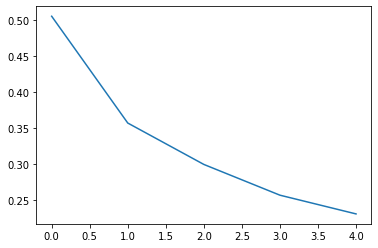

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(train_losses)

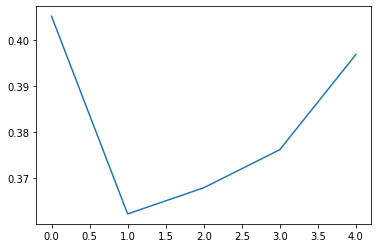

In [30]:
plt.figure()
plt.plot(val_losses)

In [31]:
# _model = model

## Run prediction

In [32]:
import torch
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

# out_dir = './Models/fine-tuned-tweetbert_v2'
out_dir = './Models/fine-tuned-twhinbert'

model = AutoModelForSequenceClassification.from_pretrained(out_dir)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [33]:
# model.classifier.out_proj.weight.sum(), _model.classifier.out_proj.weight.sum()

In [34]:
batch_size = 32

test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []
with torch.no_grad():
    model.eval()
    for k, (mb_x, mb_m) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        output = model(mb_x, attention_mask=mb_m)
        outputs.append(output[0].to('cpu'))

outputs = torch.cat(outputs)


In [35]:
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()
true_values = test_y.numpy()


In [36]:
sum(predicted_values)

341

In [37]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)
print("F1 Score:", f1_score(true_values, predicted_values, average="macro"))


print(classification_report(true_values, predicted_values, target_names=[str(l) for l in label_values]))


Test Accuracy: 0.8335714285714285
F1 Score: 0.7761643126865154
              precision    recall  f1-score   support

  not sexist       0.89      0.89      0.89      1050
      sexist       0.67      0.65      0.66       350

    accuracy                           0.83      1400
   macro avg       0.78      0.77      0.78      1400
weighted avg       0.83      0.83      0.83      1400



In [38]:
import itertools
from matplotlib import pyplot as plt

# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[938 112]
 [121 229]]


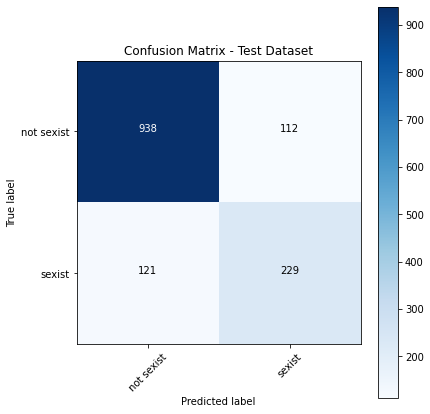

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=2)

plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
# plt.figure(figsize=(6,6))
# plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)


## Create Submissions

In [40]:
ls Data

dev_task_a_entries.csv  dev_task_c_entries.csv  test_task_a_entries.csv
dev_task_b_entries.csv  starting_ki/


In [46]:
traina = pd.read_csv("../Data/starting_ki/train_all_tasks.csv")
deva = pd.read_csv("../Data/dev_task_a_entries.csv")
testa = pd.read_csv("../Data/test_task_a_entries.csv")

In [63]:
targetdf = testa
split = "test"
texts = targetdf['text'].values

In [64]:
# text_ids = [tokenizer.encode(normalizeTweet(text), max_length=100, padding='max_length', truncation=True) for text in texts]
text_ids = [tokenizer.encode(text, max_length=100, padding='max_length', truncation=True) for text in texts]
att_masks = []
for ids in text_ids:
    masks = [int(id > 0) for id in ids]
    att_masks.append(masks)

test_x = torch.tensor(text_ids);
test_m = torch.tensor(att_masks);

In [65]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32
test_data = TensorDataset(test_x, test_m)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

outputs = []
with torch.no_grad():
    model.eval()
    for k, (mb_x, mb_m) in enumerate(test_dataloader):
        mb_x = mb_x.to(device)
        mb_m = mb_m.to(device)
        output = model(mb_x, attention_mask=mb_m)
        outputs.append(output[0].to('cpu'))

outputs = torch.cat(outputs)
_, predicted_values = torch.max(outputs, 1)
predicted_values = predicted_values.numpy()

In [66]:
label_map = {
    0: 'not sexist',
    1: 'sexist', 
    'not sexist':0,
    'sexist':1,
}

def number_to_label(label):
  return label_map[label]

predicted_labels = list(map(number_to_label, predicted_values))

In [67]:
targetdf["label_pred"] = predicted_labels

In [68]:
targetdf

,rewire_id,text,label_pred
0,sexism2022_english-7207,Here on the Oregon coast it doesn't snow. It's...,not sexist
1,sexism2022_english-10731,"""That tall man must certaily be better with wo...",sexist
2,sexism2022_english-11374,"hit the rode chode, this ain't the subreddit f...",not sexist
3,sexism2022_english-7356,The lawyer chick will shoot down the McDonald'...,not sexist
4,sexism2022_english-11976,"True, it's totally hating on females to want t...",not sexist
...,...,...,...
3995,sexism2022_english-4434,The West/teh jooz/the govt/the gynocracry is s...,not sexist
3996,sexism2022_english-6023,"Damn I got down voted to hell. Friends do lie,...",not sexist
3997,sexism2022_english-5208,"If I approach an attractive women, I'm trying ...",not sexist
3998,sexism2022_english-15798,Wow. So all women are sluts or whores. I've ne...,sexist


In [69]:
targetdf[["rewire_id", "label_pred"]].to_csv(f"Results/1a_twhinbert_{split}.csv", index=False)